In [1]:
import pandas as pd
import os
import shutil
import pickle

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras import backend
import numpy as np
import cv2 as cv
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#from google.colab import drive
#drive.mount('/content/gdrive')

Using TensorFlow backend.


In [2]:
# To get reproducible results 
np.random.seed(1234)
tf.random.set_seed(1234)

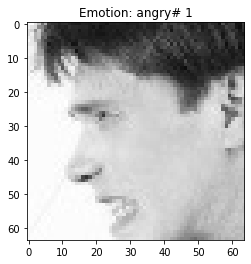

(64, 64, 3)


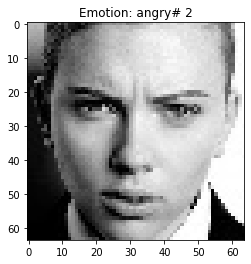

(64, 64, 3)


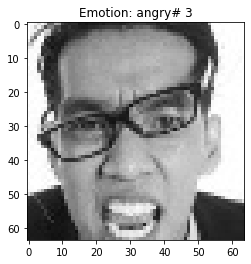

(64, 64, 3)


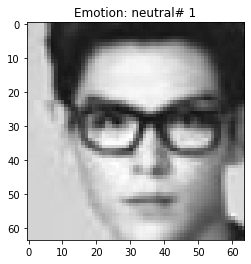

(64, 64, 3)


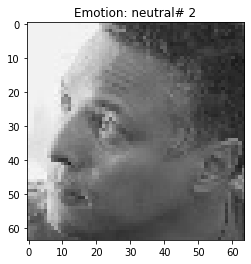

(64, 64, 3)


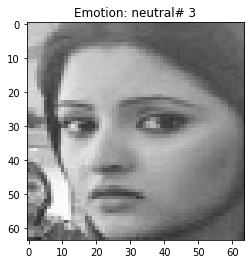

(64, 64, 3)


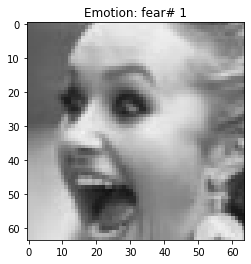

(64, 64, 3)


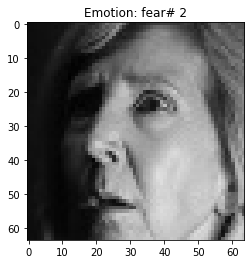

(64, 64, 3)


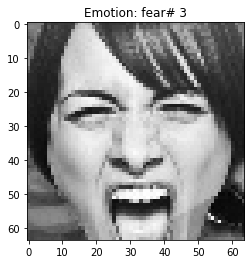

(64, 64, 3)


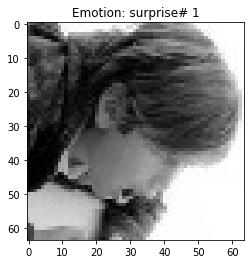

(64, 64, 3)


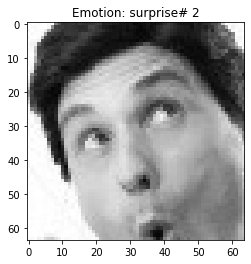

(64, 64, 3)


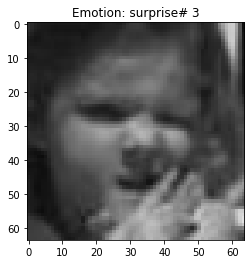

(64, 64, 3)


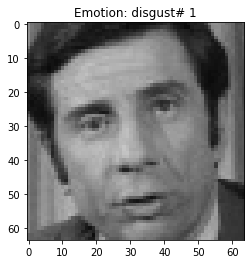

(64, 64, 3)


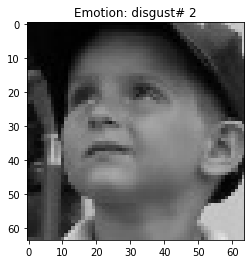

(64, 64, 3)


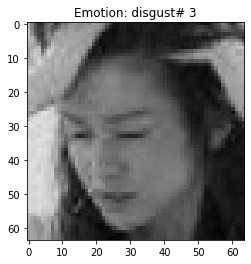

(64, 64, 3)


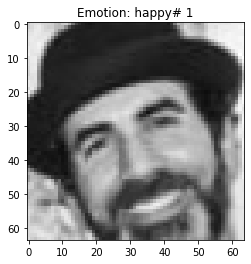

(64, 64, 3)


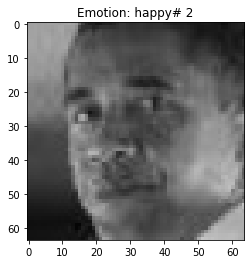

(64, 64, 3)


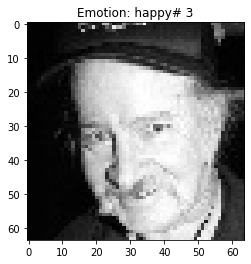

(64, 64, 3)


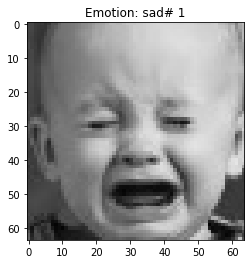

(64, 64, 3)


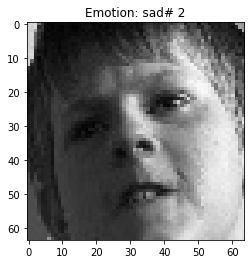

(64, 64, 3)


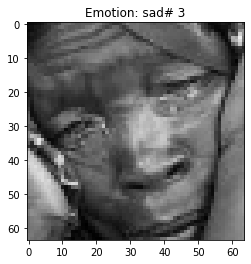

(64, 64, 3)


In [3]:
folder = '/home/lepopal/cpe428/finalproject/combined/train' # data/train
for emotion in os.listdir(folder):
  path_name = os.path.join(folder, emotion)
  count = 1
  for img_name in os.listdir(path_name)[:3]:
    file_name = os.path.join(path_name, img_name)
    img = cv.imread(file_name)
    plt.title("Emotion: " + str(emotion) + "# " + str(count))
    plt.imshow(img, cmap='Greys')
    plt.show()
    count += 1
    print(img.shape)


Create the model.

In [4]:
# from https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = keras.backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = keras.backend.sum(keras.backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = keras.backend.sum(keras.backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = keras.backend.sum(keras.backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + keras.backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + keras.backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = keras.backend.mean((1 + bb) * (p * r) / (bb * p + r + keras.backend.epsilon()))
	return fbeta_score

In [5]:
# ResNet152V2 model
in_shape = (64, 64, 3)
out_shape = 7


resnet_last_layers = ['conv5_block1_preact_bn',
'conv5_block1_1_conv',
'conv5_block1_1_bn',
'conv5_block1_2_conv',
'conv5_block1_2_bn',
'conv5_block1_0_conv',
'conv5_block1_3_conv',
'conv5_block2_preact_bn',
'conv5_block2_1_conv',
'conv5_block2_1_bn',
'conv5_block2_2_conv',
'conv5_block2_2_bn',
'conv5_block2_3_conv',
'conv5_block3_preact_bn',
'conv5_block3_1_conv',
'conv5_block3_1_bn',
'conv5_block3_2_conv',
'conv5_block3_2_bn',
'conv5_block3_3_conv',
'post_bn']

model = keras.applications.ResNet152V2(include_top=False, input_shape=in_shape)
# mark loaded layers as not trainable
for layer in model.layers: 
  layer.trainable = False

# allow last conv block to be trainable
# for layer in resnet_last_layers:
#     model.get_layer(layer).trainable = True
    
for layer in model.layers[-20:]: # make the last 20 layers trainable
    layer.trainable = True

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(out_shape, activation='sigmoid')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), # 0.001 # small learning rate
              metrics=['accuracy', fbeta])

In [8]:
img_width, img_height = 64, 64

train_data_dir = 'combined/train'
validation_data_dir = 'combined/validation'

# count the number of training images
nb_train_samples = sum([len(files) for r, d, files in os.walk(train_data_dir)])
# count number of validation images 
nb_validation_samples = sum([len(files) for r, d, files in os.walk(validation_data_dir)])
epochs = 200
batch_size = 256

# Consider converting image to grayscale before training?
input_shape = (img_width, img_height, 3)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

# this is the augmentation configuration we will use for validation
# only rescaling and preprocessing
val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical') # categorical

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical') # categorical

Found 99449 images belonging to 7 classes.
Found 12609 images belonging to 7 classes.


In [10]:
my_callbacks = []

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
my_callbacks.append(lr_reducer)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
my_callbacks.append(early_stopper)

filepath = "tl-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpointer = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
my_callbacks.append(checkpointer)

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size, # batch_size
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size, # batch_size
    shuffle=True,
    callbacks=my_callbacks)

Epoch 1/200
388/388 [==============================] - 120s 310ms/step - loss: 1.6386 - accuracy: 0.3467 - fbeta: 0.5536 - val_loss: 2.2332 - val_accuracy: 0.3080 - val_fbeta: 0.5383

Epoch 00001: val_loss improved from inf to 2.23318, saving model to tl-weights-improvement-01-0.31.hdf5
Epoch 2/200
388/388 [==============================] - 111s 285ms/step - loss: 1.5192 - accuracy: 0.4166 - fbeta: 0.5278 - val_loss: 1.8448 - val_accuracy: 0.3106 - val_fbeta: 0.5280

Epoch 00002: val_loss improved from 2.23318 to 1.84479, saving model to tl-weights-improvement-02-0.31.hdf5
Epoch 3/200
388/388 [==============================] - 112s 288ms/step - loss: 1.4703 - accuracy: 0.4446 - fbeta: 0.4606 - val_loss: 1.7948 - val_accuracy: 0.3113 - val_fbeta: 0.3106

Epoch 00003: val_loss improved from 1.84479 to 1.79484, saving model to tl-weights-improvement-03-0.31.hdf5
Epoch 4/200
388/388 [==============================] - 110s 282ms/step - loss: 1.4385 - accuracy: 0.4581 - fbeta: 0.4226 - val_l

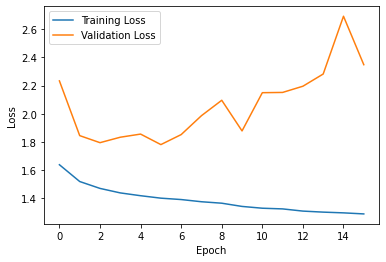

KeyError: 'sparse_categorical_accuracy'

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
history